In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext watermark
%watermark -ptorch,pandas,numpy -m

torch 0.4.1
pandas 0.22.0
numpy 1.15.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.10.0-32-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
from pathlib import Path
import itertools
from collections import Counter
from functools import partial, reduce

import joblib
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit
from fastai.text import (
    TextDataset, SortishSampler, SortSampler, DataLoader, ModelData, get_rnn_classifier, seq2seq_reg, 
    RNN_Learner, TextModel, to_gpu, LanguageModelLoader, LanguageModelData
)
from fastai.core import T
from fastai.rnn_reg import EmbeddingDropout
from fastai.text import accuracy
from torch.optim import Adam
import torch.nn as nn
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [4]:
path = Path("../data/cache/lm_word_douban/")
path.mkdir(parents=True, exist_ok=True)

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Import And Tokenize Comments and Ratings

In [6]:
UNK = 2
BEG = 1
MIN_FREQ_WORD = 200
VOC_SIZE_WORD = 30000
EMB_DIM = 300

In [7]:
mapping_orig = joblib.load("../data/mapping_word.pkl")
df_ratings = pd.read_csv("../data/ratings_word.csv")
df_ratings.head()

,comment,rating
0,别 拿 矫揉造作 的 资产阶级 情调 麻醉 中国 人民 ！,1
1,文青 们 向往 的 生活 ， 可是 生活 中 没有 了 喜怒哀乐 ， 没有 了 问题 与 冲...,2
2,自由 也许 在 大理 ， 生活 确实 在 别处 。,3
3,原来 八旬 是 小四 的 老公 ， 小 彩旗 的 爹 ， 杨丽萍 的 妹夫 。,3
4,关于 大理 的 蓝光 旅游 宣传片 。,3


### Refit the Vocabulary

In [8]:
df_ratings.iloc[:10]["comment"].str.lower().str.split(" ")

0             [别, 拿, 矫揉造作, 的, 资产阶级, 情调, 麻醉, 中国, 人民, ！]
1    [文青, 们, 向往, 的, 生活, ，, 可是, 生活, 中, 没有, 了, 喜怒哀乐, ...
2                 [自由, 也许, 在, 大理, ，, 生活, 确实, 在, 别处, 。]
3    [原来, 八旬, 是, 小四, 的, 老公, ，, 小, 彩旗, 的, 爹, ，, 杨丽萍,...
4                          [关于, 大理, 的, 蓝光, 旅游, 宣传片, 。]
5                                              [嫉妒, 啊]
6                                             [oh, 大理]
7       [虽然, 完全, 没有, 拍, 出, 大理, 的, 美, ，, 还是, 极其, 向往, 。]
8                         [大理, ，, 大理国, ，, 大理, 想, 国, 。]
9    [把, 大理, 炒, 热, 了, 可是, 人民, 却, 没有, 以前, 那样, 热爱, 大理...
Name: comment, dtype: object

In [9]:
cnt = Counter(itertools.chain.from_iterable(df_ratings["comment"].str.lower().str.split(" ")))
cnt.most_common(10)

[('，', 1389819),
 ('的', 1346692),
 ('。', 862231),
 ('是', 419776),
 ('了', 411745),
 ('不', 265731),
 ('看', 201927),
 ('一', 184012),
 ('！', 180414),
 ('我', 177160)]

In [10]:
cnt.most_common(VOC_SIZE_WORD)[-10:]

[('大伙儿', 21),
 ('奖牌', 21),
 ('怀才不遇', 21),
 ('青红', 21),
 ('体育运动', 21),
 ('云霄', 21),
 ('佯装', 21),
 ('...3', 21),
 ('检', 21),
 ('懂么', 21)]

In [76]:
mapping = {
    word: token + 3 for token, (word, freq) in enumerate(
        cnt.most_common(VOC_SIZE_WORD))
    if freq > MIN_FREQ_WORD
}
n_toks = len(mapping)
itos = ["pad", "BEG", "UNK"] + [0] *  n_toks
for k, v in mapping.items():
    itos[v] = k
n_toks = len(itos) + 1
len(itos)

6713

In [144]:
voc_diff = set(mapping.keys()) - set(mapping_orig.keys())
sorted([(x, mapping[x]) for x in list(voc_diff)], key=lambda x: x[1], reverse=True)[:50]

[('撞车', 6712),
 ('荡气回肠', 6711),
 ('跳脱', 6708),
 ('完成度', 6707),
 ('慌', 6706),
 ('孰', 6701),
 ('情色片', 6697),
 ('6.', 6695),
 ('膜拜', 6692),
 ('不可否认', 6691),
 ('尔冬', 6690),
 ('帕索里尼', 6689),
 ('浴室', 6688),
 ('华生', 6687),
 ('影坛', 6685),
 ('钢铁侠', 6684),
 ('政治片', 6682),
 ('少爷', 6681),
 ('戴安娜', 6680),
 ('落魄', 6678),
 ('霓虹', 6676),
 ('眼花缭乱', 6674),
 ('闷片', 6672),
 ('巴赫', 6671),
 ('拧', 6667),
 ('理所当然', 6666),
 ('凄凉', 6665),
 ('表象', 6662),
 ('坚信', 6661),
 ('硬生生', 6660),
 ('徘徊', 6658),
 ('力气', 6657),
 ('李政宰', 6656),
 ('吴君如', 6655),
 ('朱茵', 6654),
 ('梁咏琪', 6653),
 ('林熙蕾', 6652),
 ('骨', 6651),
 ('波兰斯基', 6650),
 ('分量', 6647),
 ('试试', 6645),
 ('贫民窟', 6644),
 ('老人家', 6643),
 ('满屏', 6642),
 ('来看', 6641),
 ('光鲜', 6639),
 ('跨度', 6637),
 ('挺烂', 6632),
 ('虐杀', 6631),
 ('难得一见', 6629)]

In [12]:
itos[-10:]

['名声', '不符', '灵活', '慌', '完成度', '跳脱', '智利', '托', '荡气回肠', '撞车']

### Tokenize

In [13]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=888)
train_idx, test_idx = next(sss.split(df_ratings, df_ratings.rating))
df_train = df_ratings.iloc[train_idx].copy()
df_test = df_ratings.iloc[test_idx].copy()
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=888)
val_idx, test_idx = next(sss.split(df_test, df_test.rating))
df_val = df_test.iloc[val_idx].copy()
df_test = df_test.iloc[test_idx].copy()
del df_ratings

In [14]:
df_test.iloc[1]["comment"],[mapping.get(x, UNK) for x in df_test.iloc[1]["comment"].split(" ")]

('老师 你 太 可爱', [607, 46, 25, 277])

In [15]:
results = []
tokens_train, tokens_val, tokens_test = [], [], []
for df, tokens in zip((df_train, df_val, df_test), (tokens_train, tokens_val, tokens_test)) :
    for i, row in tqdm_notebook(df.iterrows(), total=df.shape[0]):
        tokens.append(np.array([BEG] + [mapping.get(x, UNK) for x in row["comment"].split(" ")]))

In [16]:
assert len(tokens_train) == df_train.shape[0]

In [74]:
tokens_val[0]

array([  1, 198, 137,  90,   2])

In [75]:
df_val.iloc[0]

comment    男 主角 像 卡卡
rating             2
label              0
Name: 681247, dtype: object

### Prepare the embedding matrix

In [17]:
MODEL_PATH = "../data/cache/lm_word/models/lm_lstm.h5"
weights = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)
assert weights['0.encoder.weight'].shape[1] == EMB_DIM
weights['0.encoder.weight'].shape

torch.Size([9697, 300])

In [18]:
new_matrix = np.zeros((n_toks, EMB_DIM))
hits = 0
for i, w in enumerate(itos):
    if w in mapping_orig:
        new_matrix[i] = weights['0.encoder.weight'][mapping_orig[w]]
        hits += 1
hits, hits *100 / len(itos[3:])

(3851, 57.39195230998509)

In [19]:
weights['0.encoder.weight'] = T(new_matrix)
weights['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_matrix))
weights['1.decoder.weight'] = T(np.copy(new_matrix))

## Languange Model

In [20]:
bs = 64
bptt = 50
trn_dl = LanguageModelLoader(np.concatenate(tokens_train), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(tokens_val), bs, bptt)

In [21]:
np.max(np.array(list(itertools.chain.from_iterable(tokens_train))))

6712

In [26]:
model_data = LanguageModelData(path, 1, n_toks, trn_dl, val_dl, bs=bs, bptt=bptt)

In [27]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
opt_fn = partial(torch.optim.Adam, betas=(0.8, 0.99))

In [28]:
learner = model_data.get_model(opt_fn, EMB_DIM, 500, 3, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])
learner.metrics = [accuracy]
learner.freeze_to(-1)

In [29]:
learner.model.load_state_dict(weights)

In [30]:
lr=1e-3
lrs = lr
learner.fit(lrs/2, 1, wds=1e-7, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      8.000923   7.639961   0.122279  



[7.6399610919741345, 0.12227886706528822]

In [29]:
learner.save('lm_last_ft')

In [31]:
learner.unfreeze()
learner.clip = 25
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                     
    0      4.765055   4.627863   0.237631  



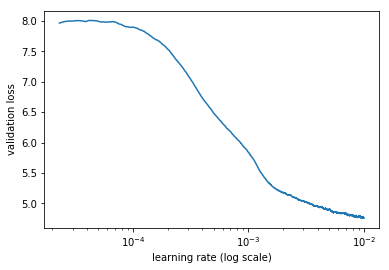

In [32]:
learner.sched.plot()

In [33]:
lr = 3e-3
lrs = lr
learner.fit(lrs, 1, wds=1e-7, use_clr=(20,5), cycle_len=10)

epoch      trn_loss   val_loss   accuracy                     
    0      4.850235   4.698425   0.235259  
    1      4.657073   4.510859   0.248149                     
    2      4.537391   4.414372   0.255944                     
    3      4.46625    4.359282   0.260501                     
    4      4.443026   4.32516    0.263364                     
    5      4.405089   4.300793   0.265203                     
    6      4.377639   4.280795   0.266945                     
    7      4.354721   4.265673   0.268153                     
    8      4.341965   4.254113   0.269288                     
    9      4.339367   4.2459     0.270085                     



[4.245900204567493, 0.2700846901222713]

In [34]:
learner.save_encoder("lm1_enc")

In [35]:
learner.save("lm1")

In [41]:
del learner

## 3-class Classifier
As in https://zhuanlan.zhihu.com/p/27198713

### Full Dataset (v1)

In [36]:
for df in (df_train, df_val, df_test):
    df["label"] = (df["rating"] >= 3) * 1
    df.loc[df.rating == 3, "label"] = 1
    df.loc[df.rating > 3, "label"] = 2

In [37]:
df_train.label.value_counts()

2    240094
1    184124
0    104406
Name: label, dtype: int64

In [188]:
bs = 64
trn_ds = TextDataset(tokens_train, df_train.label.values)
val_ds = TextDataset(tokens_val, df_val.label.values)
trn_samp = SortishSampler(tokens_train, key=lambda x: len(tokens_train[x]), bs=bs//2)
val_samp = SortSampler(tokens_val, key=lambda x: len(tokens_val[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=0, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [189]:
dps = np.array([0.4,0.5,0.05,0.3,0.4]) * 0.5
opt_fn = partial(torch.optim.Adam, betas=(0.7, 0.99))
bptt = 50

In [190]:
model = get_rnn_classifier(bptt, bptt*2, 3, n_toks, emb_sz=EMB_DIM, n_hid=500, n_layers=3, pad_token=0,
          layers=[EMB_DIM*3, 50, 3], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [191]:
learn = RNN_Learner(model_data, TextModel(to_gpu(model)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]
learn.load_encoder('lm1_enc')

 80%|████████  | 13271/16520 [02:04<00:30, 106.90it/s, loss=2.72] 

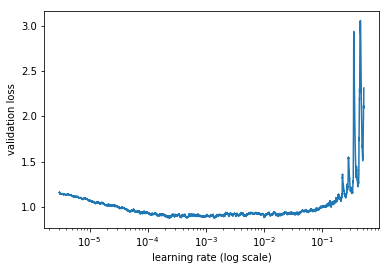

In [45]:
learn.freeze_to(-1)
learn.lr_find(lrs/1000)
learn.sched.plot()

In [46]:
lr=1e-4
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                         
    0      0.882637   0.851067   0.596267  


[0.8510666038818345, 0.5962669118314718]

In [47]:
learn.save('clas_0')

In [48]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                        
    0      0.909291   0.838445   0.603139  


[0.838444728449949, 0.6031394715336421]

In [49]:
learn.save('clas_1')

In [50]:
learn.unfreeze()
learn.fit(lrs, 1, wds=0, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                        
    0      0.879954   0.833281   0.60512   
    1      0.868686   0.823808   0.612203                        
    2      0.844532   0.815001   0.615386                        
    3      0.854847   0.809263   0.61895                         
    4      0.855106   0.803011   0.621725                        
    5      0.84975    0.798307   0.624886                        
    6      0.840797   0.798804   0.626214                        
    7      0.843157   0.800835   0.626663                        
    8      0.823333   0.795596   0.627815                        
    9      0.838305   0.792557   0.628887                        
    10     0.842246   0.791693   0.628496                        
    11     0.815797   0.791085   0.629012                        
    12     0.81966    0.792271   0.628422                        
    13     0.811767   0.789824   0.629693                        


[0.7898236833973498, 0.629693316989013]

In [51]:
learn.save("clas_full")

#### Evaluate

In [198]:
learn.load("clas_full")
learn.model.reset()
_ = learn.model.eval()

In [53]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm_notebook(val_dl):
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [54]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((176208,), (176208,))

In [55]:
pd.Series(ys).value_counts()

2    80031
1    61374
0    34803
dtype: int64

In [56]:
pd.Series(preds).value_counts()

2    97951
1    50965
0    27292
dtype: int64

In [57]:
np.sum(ys==preds) / ys.shape[0]

0.629693316989013

In [59]:
np.where(ys==0)

(array([     6,      9,     24, ..., 176196, 176205, 176207]),)

In [77]:
"".join([str(itos[x]) for x in tokens_val[176196]]), df_val["comment"].iloc[176196]

('BEG如此的欺骗，或许我也就UNK了，有什么呢', '如此 的 欺骗 ， 或许 我 也 就 释然 了 ， 有 什么 呢')

In [78]:
"".join([str(itos[x]) for x in tokens_val[0]]), df_val["comment"].iloc[0]

('BEG男主角像UNK', '男 主角 像 卡卡')

In [193]:
def get_prediction(texts):
    input_tensor = T(np.array([1] + [mapping.get(x, UNK) for x in texts])).unsqueeze(1)
    return learn.model(input_tensor)[0].data.cpu().numpy()

In [199]:
get_prediction("看了快一半了才发现是mini的广告")

array([[0.09, 0.08, 0.31]], dtype=float32)

In [200]:
get_prediction("妈蛋，简直太好看了。最后的DJ battle部分，兴奋的我，简直想从座位上站起来一起扭")

array([[-1.73,  0.17,  1.25]], dtype=float32)

In [201]:
get_prediction("说实话我没怎么认真看，电影院里的熊孩子太闹腾了，前面的小奶娃还时不时站在老爸腿上蹦迪，观影体验极差，不过小朋友应该挺喜欢的")

array([[-0.4 ,  0.54,  0.13]], dtype=float32)

In [202]:
get_prediction("这电影太好笑了，说好的高科技人才研制的产品永远在关键时候失灵；特地飞到泰国请来救援人才，大家研究出的方法每次都是先给鲨鱼当诱饵……显然这样的对战坚持不了多久，只能赶紧让鲨鱼输了。")

array([[-0.89,  0.43,  0.96]], dtype=float32)

In [203]:
get_prediction("太接地气了，在三亚煮饺子式的景区海域，冒出来一条大鲨鱼……爽点也很密集，郭达森与李冰冰的CP感不错，编剧果然是老外，中文台词有点尬。")

array([[-0.35,  0.38, -0.01]], dtype=float32)

In [204]:
get_prediction("李冰冰的脸真的很紧绷，比鲨鱼的脸还绷。")

array([[-0.85,  0.32,  0.51]], dtype=float32)

In [205]:
get_prediction("太难了。。。")

array([[ 0.57,  0.19, -0.19]], dtype=float32)

In [206]:
get_prediction("把我基神写成智障，辣鸡mcu")

array([[ 0.13, -0.16,  0.47]], dtype=float32)

In [207]:
get_prediction("鲨鱼部分还是不错的，尤其是中段第一次出海捕鲨非常刺激，其后急速下滑，三亚那部分拍得是什么鬼。。。爆米花片可以适度的蠢，但人类反派炸鲨和直升机相撞部分简直蠢得太过份了吧？另外充满硬加戏视感的尴尬感情戏把节奏也拖垮了，明明可以更出色，却很遗憾地止步在马马虎虎的水平。6/10")

array([[ 0.3 ,  0.52, -1.17]], dtype=float32)

In [208]:
get_prediction("老冰冰真的很努力！为老冰冰实现了她的好莱坞女主梦鼓掌...")

array([[-1.8 ,  0.16,  1.17]], dtype=float32)

In [209]:
get_prediction("结局简直丧出天际！灭霸竟然有内心戏！全程下来美队和钢铁侠也没见上一面，我还以为在世界末日前必然要重修旧好了！")

array([[-0.13,  0.32,  0.3 ]], dtype=float32)

In [210]:
get_prediction("太烂了，难看至极。")

array([[ 2.12, -1.2 , -2.24]], dtype=float32)

In [211]:
get_prediction("看完之后很生气！剧情太差了")

array([[ 0.85,  0.11, -0.15]], dtype=float32)

In [212]:
get_prediction("关键点都好傻，我知道你要拍续集，我知道未来可以被重写， 但那一拳真的有点傻。")

array([[ 0.43,  0.34, -0.29]], dtype=float32)

In [213]:
get_prediction("好了可以了。再也不看Marvel了。我努力过了。实在是。。啥呀这是。🙄️")

array([[-0.01, -0.16,  0.37]], dtype=float32)

In [214]:
get_prediction("还我电影票14元")

array([[ 0.83, -0.48, -0.1 ]], dtype=float32)

Confusion matrix, without normalization
[[17619 10322  6862]
 [ 7041 28291 26042]
 [ 2632 12352 65047]]


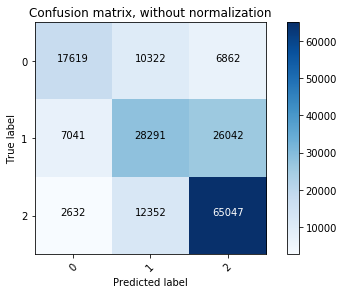

In [96]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.51 0.3  0.2 ]
 [0.11 0.46 0.42]
 [0.03 0.15 0.81]]


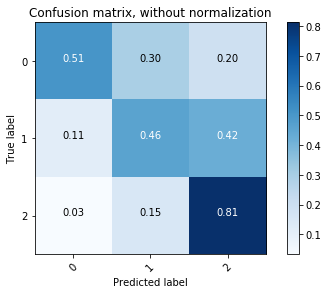

In [97]:
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [98]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 65%, R 51%, FS 0.57, Support: 34803
Class 1: P 56%, R 46%, FS 0.50, Support: 61374
Class 2: P 66%, R 81%, FS 0.73, Support: 80031


In [99]:
test_ds = TextDataset(tokens_test, df_test.label.values)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=test_samp)

In [100]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm_notebook(test_dl):
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [101]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((176209,), (176209,))

In [102]:
np.sum(ys==preds) / ys.shape[0]

0.6271586581843153

Confusion matrix, without normalization
[[17307 10527  6968]
 [ 7132 28199 26044]
 [ 2606 12421 65005]]


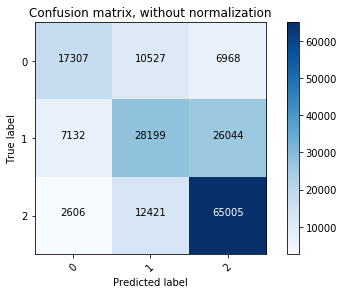

In [103]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.5  0.3  0.2 ]
 [0.12 0.46 0.42]
 [0.03 0.16 0.81]]


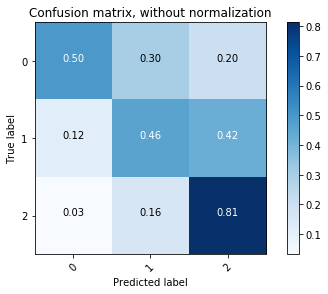

In [104]:
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [105]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 64%, R 50%, FS 0.56, Support: 34802
Class 1: P 55%, R 46%, FS 0.50, Support: 61375
Class 2: P 66%, R 81%, FS 0.73, Support: 80032


### Smaller Dataset 

In [215]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

In [216]:
df_train_small = pd.concat([
    df_train[df_train.label==0].sample(15000),
    df_train[df_train.label==1].sample(15000),
    df_train[df_train.label==2].sample(15000)
], axis=0)
df_val_small = pd.concat([
    df_val[df_val.label==0].sample(5000),
    df_val[df_val.label==1].sample(5000),
    df_val[df_val.label==2].sample(5000)
], axis=0)

In [217]:
np.array(df_train_small.index)

array([321096, 367818, 249236, ..., 260675, 408863, 225404])

In [218]:
bs = 64
tokens_train_small = np.array(tokens_train)[np.array(df_train_small.index)]
tokens_val_small = np.array(tokens_val)[np.array(df_val_small.index)]
trn_ds = TextDataset(tokens_train_small, df_train_small.label.values)
val_ds = TextDataset(tokens_val_small, df_val_small.label.values)
trn_samp = SortishSampler(tokens_train_small, key=lambda x: len(tokens_train_small[x]), bs=bs//2)
val_samp = SortSampler(tokens_val_small, key=lambda x: len(tokens_val_small[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=0, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [110]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])
opt_fn = partial(torch.optim.Adam, betas=(0.7, 0.99))
bptt = 50

In [112]:
model = get_rnn_classifier(bptt, bptt*2, 3, n_toks, emb_sz=EMB_DIM, n_hid=500, n_layers=3, pad_token=0,
          layers=[EMB_DIM*3, 50, 3], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [113]:
learn = RNN_Learner(model_data, TextModel(to_gpu(model)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]
learn.load_encoder('lm1_enc')

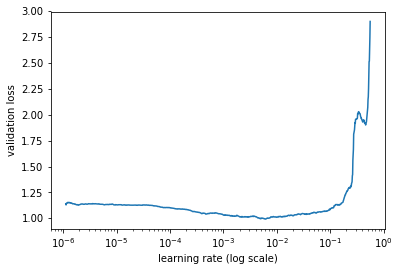

In [114]:
learn.freeze_to(-1)
learn.lr_find(lrs/100)
learn.sched.plot()

In [115]:
lr=1e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                       
    0      1.012298   0.922647   0.560333  


[0.9226470053037008, 0.5603333333651225]

In [116]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                      
    0      1.004228   0.909876   0.564867  


[0.9098755647023519, 0.5648666666666666]

In [117]:
learn.unfreeze()
learn.fit(lrs, 1, wds=0, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                      
    0      1.001542   0.904714   0.568467  
    1      0.980471   0.891081   0.571867                      
    2      0.96149    0.880097   0.581867                      
    3      0.976053   0.880369   0.582333                      
    4      0.946454   0.872783   0.581733                      
    5      0.933126   0.864392   0.584867                      
    6      0.937109   0.861721   0.589467                      
    7      0.940408   0.861515   0.584333                      
    8      0.930203   0.859928   0.590667                      
    9      0.9142     0.857158   0.588933                      
    10     0.936918   0.854491   0.5924                        
    11     0.925632   0.855096   0.589267                      
    12     0.907661   0.856662   0.589333                      
    13     0.916189   0.853918   0.589267                      


[0.8539179455121358, 0.5892666666666667]

In [119]:
learn.save("clas_small_full")

In [120]:
learn.model.eval()
preds, ys = [], []
for x, y in val_dl:
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [121]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((15000,), (15000,))

Normalized confusion matrix
[[0.64 0.2  0.15]
 [0.23 0.4  0.36]
 [0.1  0.18 0.72]]


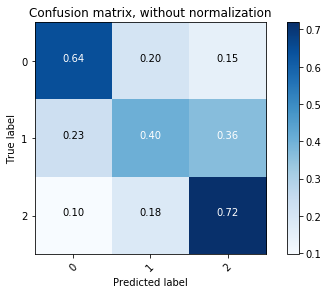

In [122]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [123]:
test_ds = TextDataset(tokens_test, df_test.label.values)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=test_samp)

In [124]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm_notebook(test_dl):
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [125]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((176209,), (176209,))

In [126]:
np.sum(preds==ys) / preds.shape[0]

0.5934884143261695

Normalized confusion matrix
[[0.64 0.21 0.15]
 [0.24 0.4  0.35]
 [0.1  0.18 0.72]]


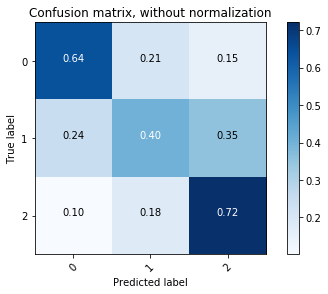

In [127]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [128]:
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 49%, R 64%, FS 0.56, Support: 34802
Class 1: P 53%, R 40%, FS 0.46, Support: 61375
Class 2: P 68%, R 72%, FS 0.70, Support: 80032


## Regressor

In [129]:
bs = 64
trn_ds = TextDataset(tokens_train, df_train.rating.values.astype("float32"))
val_ds = TextDataset(tokens_val, df_val.rating.values.astype("float32"))
trn_samp = SortishSampler(tokens_train, key=lambda x: len(tokens_train[x]), bs=bs//2)
val_samp = SortSampler(tokens_val, key=lambda x: len(tokens_val[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=0, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [131]:
dps = np.array([0.4,0.5,0.05,0.3,0.4]) * 0.5
opt_fn = partial(torch.optim.Adam, betas=(0.7, 0.99))
bptt = 50

In [133]:
model = get_rnn_classifier(bptt, bptt*2, 3, n_toks, emb_sz=EMB_DIM, n_hid=500, n_layers=3, pad_token=0,
          layers=[EMB_DIM*3, 50, 1], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [134]:
class RNN_RegLearner(RNN_Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)

    def _get_crit(self, data): return lambda x, y: F.mse_loss(x[:, 0], y)

In [135]:
learn = RNN_RegLearner(model_data, TextModel(to_gpu(model)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = []
learn.load_encoder('lm1_enc')

In [145]:
lr=1e-4
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

 80%|███████▉  | 13189/16520 [02:17<00:34, 95.58it/s, loss=1.74] 

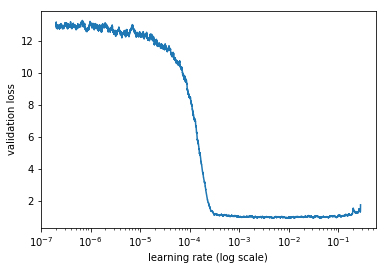

In [137]:
learn.freeze_to(-1)
learn.lr_find(lrs/1000)
learn.sched.plot()

In [146]:
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))
learn.save('reg_0')

epoch      trn_loss   val_loss                                    
    0      0.944539   0.820772  


In [147]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))
learn.save('reg_1')

epoch      trn_loss   val_loss                                   
    0      0.896087   0.797165  


In [148]:
learn.unfreeze()
learn.fit(lrs, 1, wds=0, cycle_len=14, use_clr=(32,10))
learn.save('reg_full')

epoch      trn_loss   val_loss                                   
    0      0.892857   0.780734  
    1      0.850102   0.765759                                   
    2      0.855231   0.755049                                   
    3      0.858158   0.742554                                   
    4      0.806615   0.738463                                   
    5      0.800257   0.732406                                   
    6      0.817405   0.731303                                   
    7      0.786261   0.726621                                   
    8      0.805938   0.726315                                   
    9      0.793017   0.724993                                   
    10     0.79336    0.720852                                   
    11     0.787377   0.720906                                   
    12     0.844286   0.721651                                   
    13     0.777026   0.721157                                   


In [149]:
# Export Model
torch.save(learn.model, path / "sentiment_model.pth")

In [150]:
learn.load('reg_full')

### Evaluation

In [151]:
test_ds = TextDataset(tokens_test, df_test.rating.values)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=test_samp)

In [152]:
def get_preds(data_loader):
    learn.model.eval()
    learn.model.reset()         
    preds, ys = [], []
    for x, y in tqdm_notebook(data_loader):   
        preds.append(learn.model(x)[0].cpu().data.numpy()[:, 0])
        ys.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    ys = np.concatenate(ys)
    return ys, preds
ys, preds = get_preds(val_dl)
preds.shape, ys.shape

((176208,), (176208,))

In [153]:
pd.Series(ys).describe()

count    176208.000000
mean          3.335331
std           1.080536
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           5.000000
dtype: float64

In [154]:
pd.Series(ys).describe()

count    176208.000000
mean          3.335331
std           1.080536
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           5.000000
dtype: float64

In [155]:
np.sum(np.square(preds - ys)) / preds.shape[0]

0.7211570452249614

In [156]:
preds = np.clip(preds, 1, 5)
np.sum(np.square(preds - ys)) / preds.shape[0]

0.7203134044708527

In [157]:
# Save predictions
df_val.loc[df_val.iloc[list(iter(val_samp))].index, "preds"] = preds
df_val.to_csv(path / "df_val.csv.gz", index=False, compression="gzip")
df_val.head()

,comment,rating,label,preds
0,男 主角 像 卡卡,2,0,3.177300
1,经典 改编 ， 还是 忠于 原著 的 ， 一路 都 很 稳 。,4,2,3.881618
2,叙事 ： 时间 空间 的 有机 结合,5,2,3.599128
3,看 街头 小 混混 打 外星人 挺 热闹 的 ， 可是 前 一 秒 还 在 抢劫 的 少年犯...,2,0,2.469437
4,这 电影 也 就 一般,3,1,2.753609


In [158]:
np.sum(np.square(df_val.rating.values - df_val.preds.values)) / preds.shape[0]

0.7203134228909114

In [159]:
ys, preds = get_preds(test_dl)
preds.shape, ys.shape

((176209,), (176209,))

In [160]:
preds = np.clip(preds, 1, 5)
np.sum(np.square(preds - ys)) / preds.shape[0]

0.724214991480893

In [161]:
# Save predictions
df_test.loc[df_test.iloc[list(iter(test_samp))].index, "preds"] = preds
df_test.to_csv(path / "df_test.csv.gz", index=False, compression="gzip")
df_test.head()

,comment,rating,label,preds
258461,无话可说 .,3,1,2.623072
118491,老师 你 太 可爱,5,2,4.029983
44768,说 了 好多 话 ， 可惜 都 是 陈词滥调 、 无 凭 无据 。,2,0,3.084802
34630,普巴 家用 的 电脑 是 苹果 。,3,1,3.596427
382761,这 才 是 一 部 看 完 之后 观众 讲 不 清道 不 明 的 电影 ， 主线 不 明了 ...,4,2,3.324976


In [162]:
df_test.sample(20)

,comment,rating,label,preds
314998,要 能 拍 成 外 太空 九号 那样 的 其实 也 不错 。 自 以为 不 是 就 不行 。,1,0,2.886537
289493,有 种 观影 叫练 听力,1,0,3.224998
108073,后 现代 作品 的 审美 经常 无奈 的 发现 其 先锋 的 形式 后面 却 是 个 很 平...,3,1,3.587022
88535,三 年 前 标注 的 “ 想 看 ” ， 今天 终于 看 了 ~ 中规中矩 的 纪录片 ， ...,4,2,4.349826
483684,有点 小 特别 。,4,2,3.455689
89137,温柔 的 老师 可爱 的 JOJO,4,2,4.137681
268855,以后 看到 陈思成 都会 想到 变态 吧,2,0,3.396707
709102,剧情 能 再 烂 点儿 吗 ， 演员 能 再 假 点儿 吗,1,0,1.400551
234969,ʕ• ̫͡ •ʕ * ̫͡ * ʕ• ͓͡ •ʔ - ̫ ͡ - ʕ •̫ ͡• ʔ * ̫...,4,2,3.434104
298456,凯奇 近年来 接 的 最 好 的 片子,3,1,4.186922


In [163]:
np.sum(np.square(df_test.rating.values - df_test.preds.values)) / preds.shape[0]

0.7242149914808932

In [164]:
preds_class = np.round(preds)

Confusion matrix, without normalization
[[ 1316  4475  4701  1004    26]
 [  577  6552 13621  2516    14]
 [   71  3925 37805 19421   153]
 [    6   583 17773 35001  1286]
 [    7   212  4666 18066  2432]]


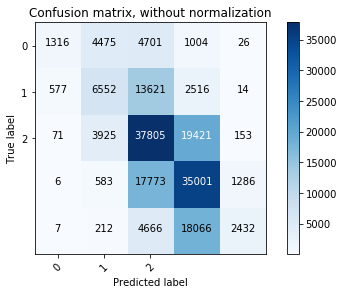

In [165]:
cnf_matrix = confusion_matrix(ys, preds_class)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

In [166]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds_class)
for i in range(5):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 67%, R 11%, FS 0.19, Support: 11522
Class 1: P 42%, R 28%, FS 0.34, Support: 23280
Class 2: P 48%, R 62%, FS 0.54, Support: 61375
Class 3: P 46%, R 64%, FS 0.54, Support: 54649
Class 4: P 62%, R 10%, FS 0.17, Support: 25383


In [177]:
def get_prediction(texts):
    input_tensor = T(np.array([1] + [mapping.get(x, UNK) for x in texts])).unsqueeze(1)
    return learn.model(input_tensor)[0].data.cpu().numpy()[0, 0]

In [178]:
get_prediction("看了快一半了才发现是mini的广告")

3.2468698

In [179]:
get_prediction("妈蛋，简直太好看了。最后的DJ battle部分，兴奋的我，简直想从座位上站起来一起扭")

3.901013

In [180]:
get_prediction("说实话我没怎么认真看，电影院里的熊孩子太闹腾了，前面的小奶娃还时不时站在老爸腿上蹦迪，观影体验极差，不过小朋友应该挺喜欢的")

3.1567433

In [181]:
get_prediction("李冰冰的脸真的很紧绷，比鲨鱼的脸还绷。")

3.5239468

In [182]:
get_prediction("太烂了，难看至极。")

1.4538441

In [183]:
get_prediction("还我电影票14元")

2.41293

In [184]:
get_prediction("好了可以了。再也不看Marvel了。我努力过了。实在是。。啥呀这是。🙄️")

3.23396

In [185]:
get_prediction("把我基神写成智障，辣鸡mcu")

3.2597156